## Импорт библиотек, подключение CUDA

In [2]:
import tensorflow as tf
import tf_keras
from tensorflow import keras
import pathlib
from pathlib import Path
import os
import natsort
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import Xception

from tensorflow.keras.models import Model
import tensorflow_hub as hub
from sklearn.model_selection import KFold

In [3]:
print("Доступные устройства:", tf.config.list_physical_devices('GPU'))

Доступные устройства: []


2024-12-03 22:49:52.591132: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0],True)

## Проверяем датасеты

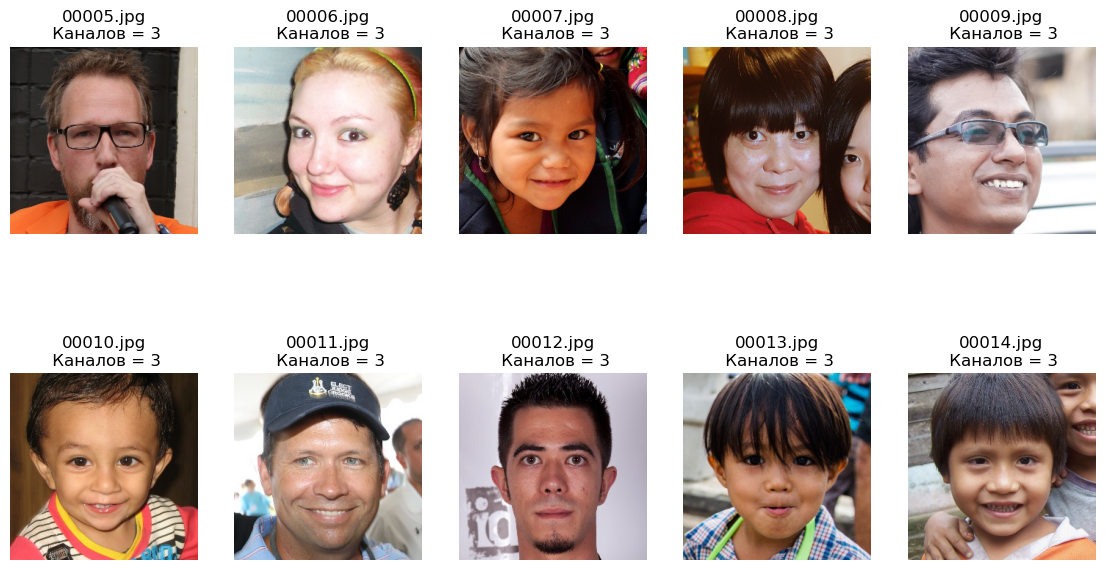

In [35]:
draw_path = '/home/waylander/Документы/dataset/draw'
draw_filenames = natsort.natsorted(os.listdir(draw_path))

generate_path = '/home/waylander/Документы/dataset/generate'
generate_filenames = natsort.natsorted(os.listdir(generate_path))

photo_path = '/home/waylander/Документы/dataset/photo'
photo_filenames = natsort.natsorted(os.listdir(photo_path))

pic_box = plt.figure(figsize=(14,12))
for i, image_name in enumerate(photo_filenames[5:15]):
    image = plt.imread(str(Path(photo_path, image_name)))
    ax = pic_box.add_subplot(3,5,i+1)
    ax.set_title(str(image_name) + '\n Каналов = ' + str(image.shape[2]))
    plt.imshow(image)
    plt.axis('off')
plt.show()

## Делим датасеты

In [37]:
import splitfolders
splitfolders.ratio('/home/waylander/Документы/dataset', '/home/waylander/Документы/splited80ds', ratio=(0.8, 0.2), seed=128, group_prefix=None)

Copying files: 90000 files [00:28, 3121.73 files/s]


## Нормализация

Found 72000 images belonging to 3 classes.
Found 18000 images belonging to 3 classes.
Количество классов: 3


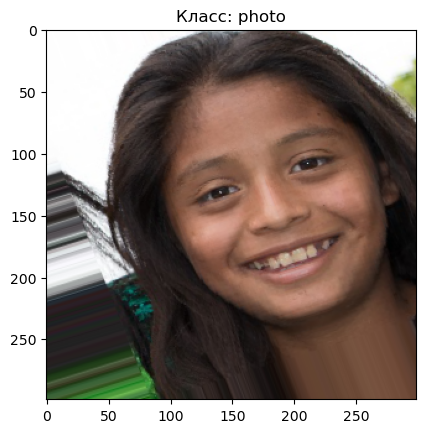

In [87]:
train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)
val = ImageDataGenerator(rescale=1/255)

train_data = train.flow_from_directory('/home/waylander/Документы/splited80ds/train', target_size=(299,299),
                          class_mode='categorical', batch_size = 32, shuffle=True)
val_data = val.flow_from_directory('/home/waylander/Документы/splited80ds/val', target_size=(299,299),
                                  class_mode='categorical', batch_size=32, shuffle=True)
classes = ['draw', 'generate', 'photo']

print("Количество классов:", len(train_data.class_indices))
sample_batch = next(train_data)
sample_image, sample_label = sample_batch[0][0], sample_batch[1][0]
plt.imshow(sample_image)
plt.title(f"Класс: {classes[np.argmax(sample_label)]}")
plt.show()

# Xception

In [117]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False

for l in base_model.layers:
    l.trainable = False

data_augmentation = keras.Sequential(
[
layers.RandomFlip("horizontal", input_shape=(299, 299, 3)),
layers.RandomRotation(0.05),
layers.RandomContrast(0.2),
layers.RandomZoom(0.2),
]
)

inputs = keras.Input(shape=(299, 299, 3))

x = data_augmentation(inputs) # Применяем аугментацию
x = base_model(x, training=False) # Передаем через базовую модель
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy', 'precision', 'recall', 'f1_score']
             )

checkpoint_filepath = '/home/waylander/Документы/dataset/best_model_xception.keras'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

/home/waylander/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [119]:
history = model.fit(
    train_data,
    epochs = 5,
    batch_size=32,
    validation_data = val_data,
    callbacks=[model_checkpoint_callback]
)

model.save('/home/waylander/Документы/ModelXception.keras')

Epoch 1/5
 109/2250 ━━━━━━━━━━━━━━━━━━━━ 1:18:39 2s/step - accuracy: 0.5078 - f1_score: 0.5072 - loss: 0.9706 - precision: 0.5444 - recall: 0.3250

KeyboardInterrupt: 

# Валидация

In [ ]:
#Allocation of 354041856 exceeds 10% of free system memory.

import time
start_time = time.time()

class_names = ['draw', 'generate', 'photo']

start_time = time.time()

print(f"Execution time: {time.time() - start_time:.2f} seconds")
print("Starting predictions on validation data...")

y_pred = model.predict(val_data)
print(f"Predictions completed. Shape of y_pred: {y_pred.shape}")

y_true = val_data.labels
print(f"True labels extracted. Shape of y_true: {y_true.shape}")

y_true = label_binarize(y_true, classes=[0, 1, 2])
print(f"True labels binarized. Shape of y_true: {y_true.shape}")

y_pred_class = np.argmax(y_pred, axis=-1)
y_pred = label_binarize(y_pred_class, classes=[0, 1, 2])
print(f"Predicted labels binarized. Shape of y_pred: {y_pred.shape}")

for i in range(3):
    print(f"Calculating ROC curve for class {class_names[i]}...")
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"Class {class_names[i]} - ROC AUC: {roc_auc:.2f}")

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for class {class_names[i]}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for class {class_names[i]}')
    plt.legend(loc="lower right")
    plt.show()
    print(f"ROC curve plotted for class {class_names[i]}")

In [ ]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score']
    for metric in metrics:
        plt.plot(history.history[metric], label=f'Training {metric.capitalize()}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_metrics(history)

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/home/waylander/Документы/Модели/ModelXception.keras')

I0000 00:00:1730976749.690781    6785 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9132 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:06:00.0, compute capability: 8.6


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = val_data.classes

cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_data.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Проверка данных

In [ ]:
model.save('/home/waylander/Документы/ModelXception.keras')

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
loadedModel = load_model('/home/waylander/Документы/ModelXception.keras')


def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    confidence = predictions[0][class_idx]

    classes = ['Draw', 'Generate', 'Real']
    predicted_class = classes[class_idx]

    plt.imshow(image.load_img(img_path, target_size=(299, 299)))
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f})")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


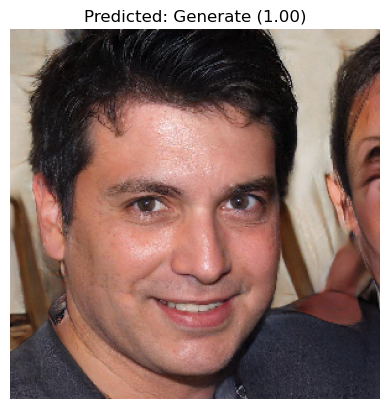

In [ ]:

predict_image('/home/waylander/Документы/Тесты/0184XNPIPY.jpg', loadedModel)